# Bike Sharing demand prediction

+ Based on Bike Sharing dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)
+ This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

### Problem Statement
Given the Bike Sharing dataset with hourly level information of bikes along with weather and other attributes, model a system which can predict the bike count.

## Import required packages

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

# modeling utilities
import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# plotting
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting params
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

sn.set_style('whitegrid')
sn.set_context('talk')

plt.rcParams.update(params)
pd.options.display.max_colwidth = 600

## Load Dataset

In [3]:
hour_df = pd.read_csv('data/hour.csv')
print("Shape of dataset::{}".format(hour_df.shape))

Shape of dataset::(17379, 17)


In [4]:
display(hour_df.head())

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Data Types and Summary Stats

In [5]:
# data types of attributes
hour_df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
# dataset summary stats
hour_df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


The dataset has:
+ 17 attributes in total and 17k+ records
+ Except `dtedat`, rest all are numeric(int or float)
+ As stated on the UCI dataset page, the following attributes have been normalized (same is confirmed above):
    + `temp`, `atemp`
    + `humidity`
    + `windspeed`
+ Dataset has many categorical variables like `season`, `yr`, `holiday`, `weathersit` and so on. 

## Standardize Attribute Names

In [7]:
hour_df.rename(columns={'instant':'rec_id',
                      'dteday':'datetime',
                      'holiday':'is_holiday',
                      'workingday':'is_workingday',
                      'weathersit':'weather_condition',
                      'hum':'humidity',
                      'mnth':'month',
                      'cnt':'total_count',
                      'hr':'hour',
                      'yr':'year'},inplace=True)

## Typecast Attributes 

In [8]:
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

## Visualize Attributes, Trends and Relationships

### Hourly distribution of Total Counts
+ Seasons are encoded as 1:spring, 2:summer, 3:fall, 4:winter
+ Exercise: Convert season names to readable strings and visualize data again

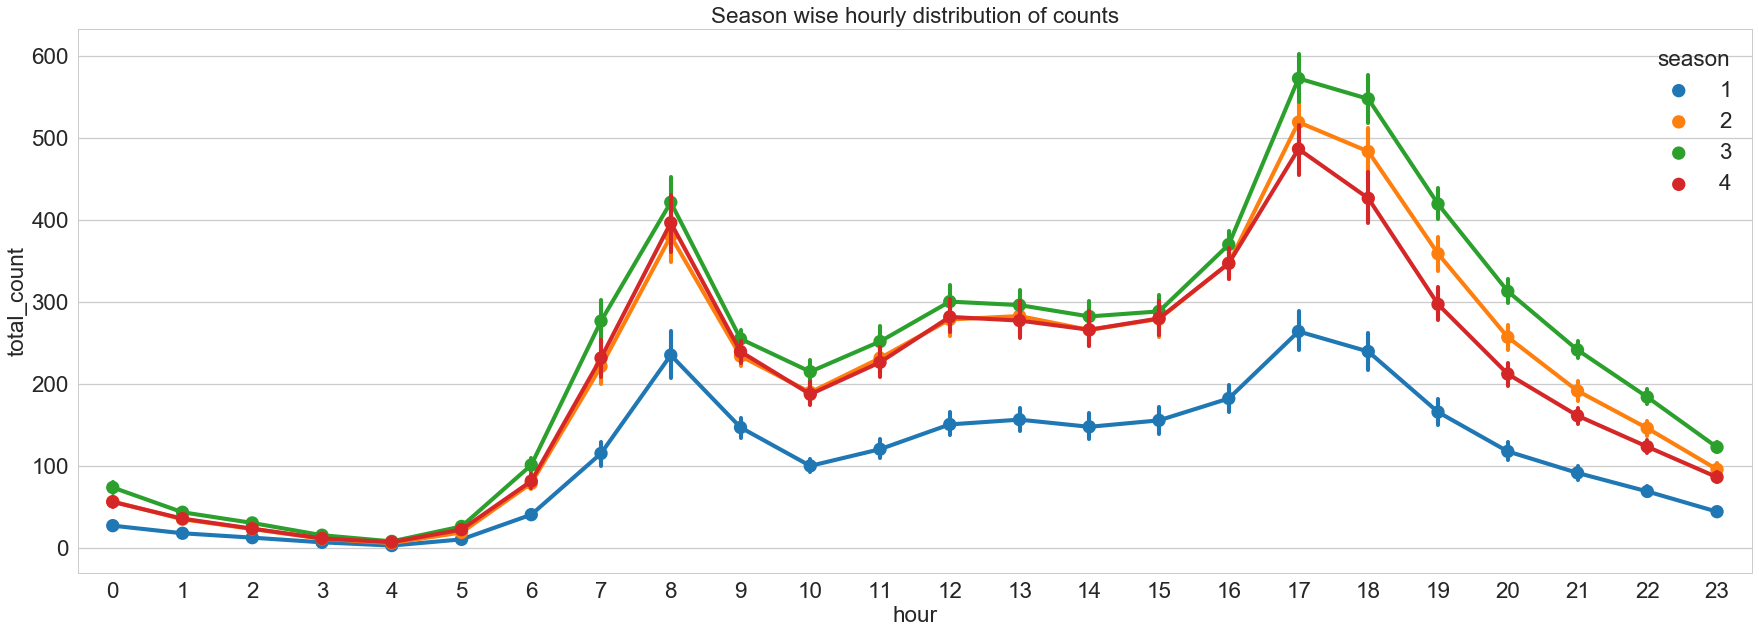

In [9]:
fig,ax = plt.subplots()
sn.pointplot(data=hour_df[['hour',
                           'total_count',
                           'season']],
             x='hour',y='total_count',
             hue='season',ax=ax)
ax.set(title="Season wise hourly distribution of counts");

+ The above plot shows peaks around 8am and 5pm (office hours)
+ Overall higher usage in the second half of the day

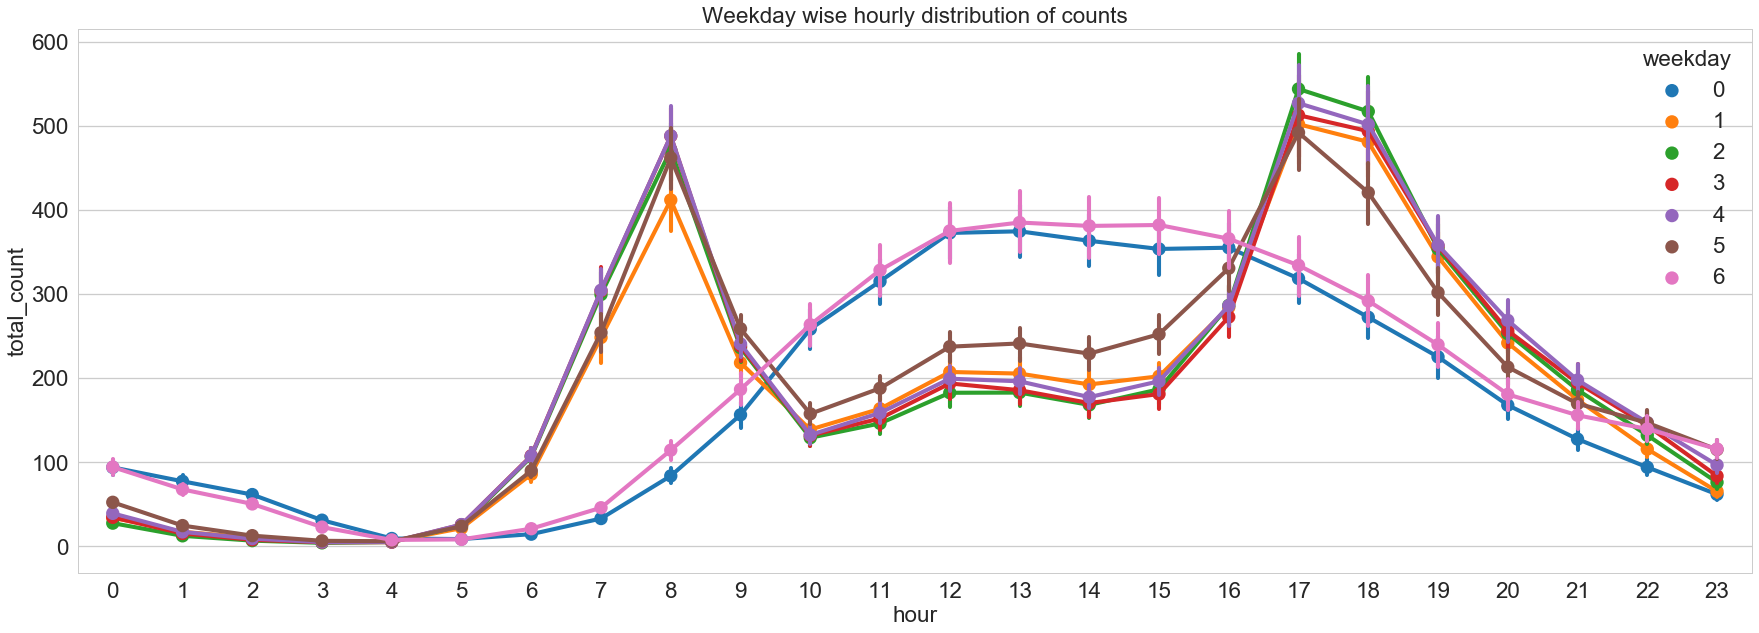

In [10]:
fig,ax = plt.subplots()
sn.pointplot(data=hour_df[['hour','total_count','weekday']],x='hour',y='total_count',hue='weekday',ax=ax)
ax.set(title="Weekday wise hourly distribution of counts");

+ Weekends (0 and 6) and Weekdays (1-5) show different usage trends with weekend's peak usage in during afternoon hours
+ Weekdays follow the overall trend, similar to one visualized in the previous plot
+ Weekdays have higher usage as compared to weekends
+ It would be interesting to see the trends for casual and registered users separately

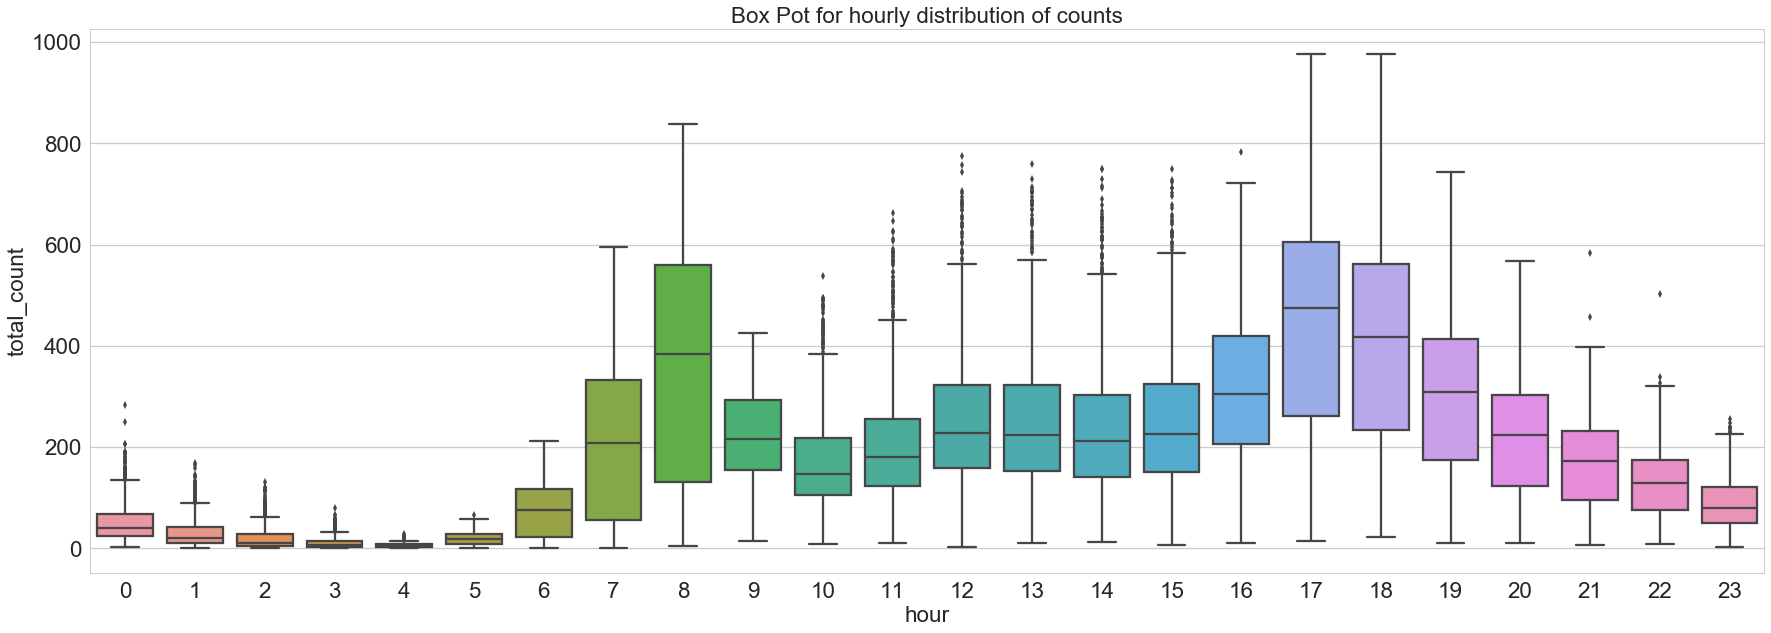

In [11]:
fig,ax = plt.subplots()
sn.boxplot(data=hour_df[['hour','total_count']],x="hour",y="total_count",ax=ax)
ax.set(title="Box Pot for hourly distribution of counts");

+ Early hours (0-4) and late nights (21-23) have low counts but significant outliers
+ Afternoon hours also have outliers
+ Peak hours have higher medians and overall counts with virtually no outliers

### Monthly distribution of Total Counts

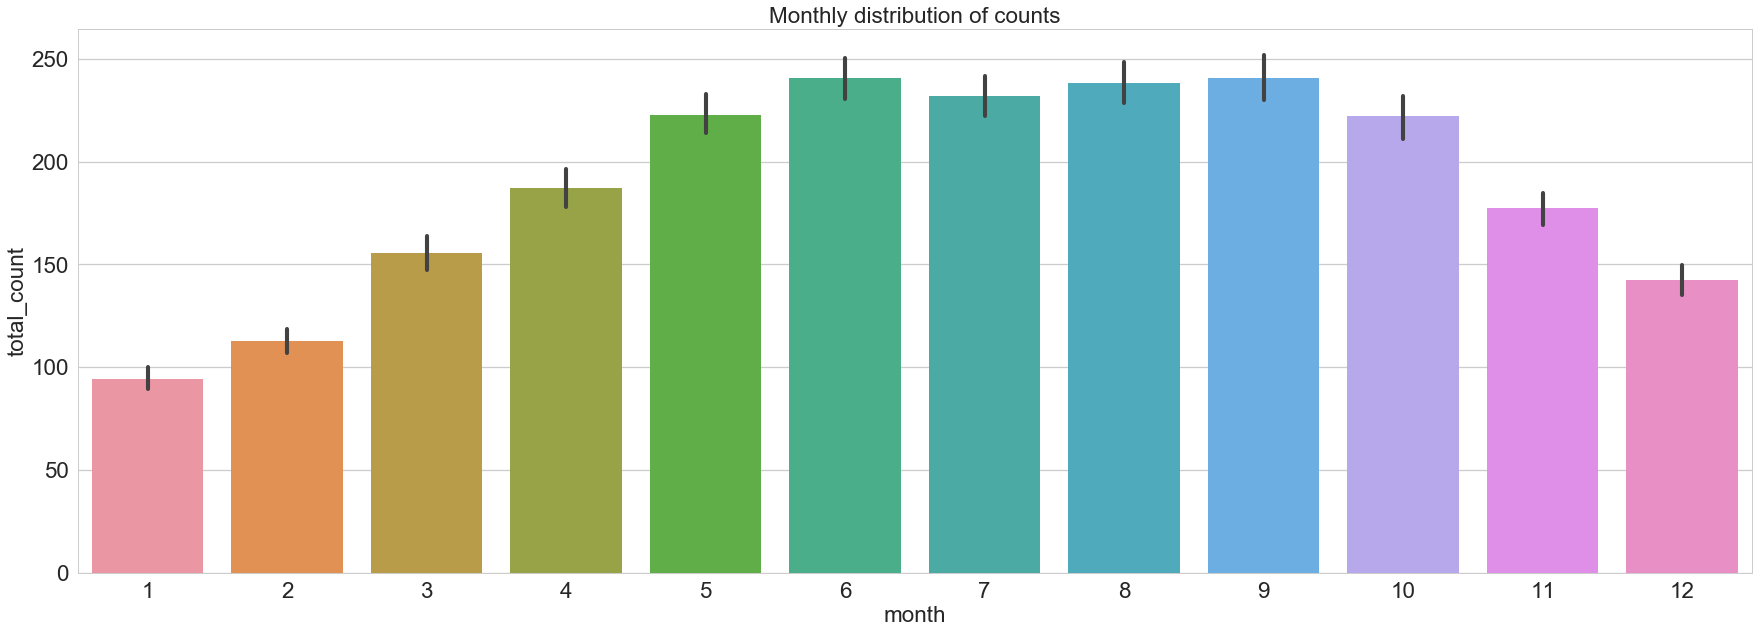

In [12]:
fig,ax = plt.subplots()
sn.barplot(data=hour_df[['month',
                         'total_count']],
           x="month",y="total_count")
ax.set(title="Monthly distribution of counts");

+ Months June-Oct have highest counts. Fall seems to be favorite time of the year to use cycles

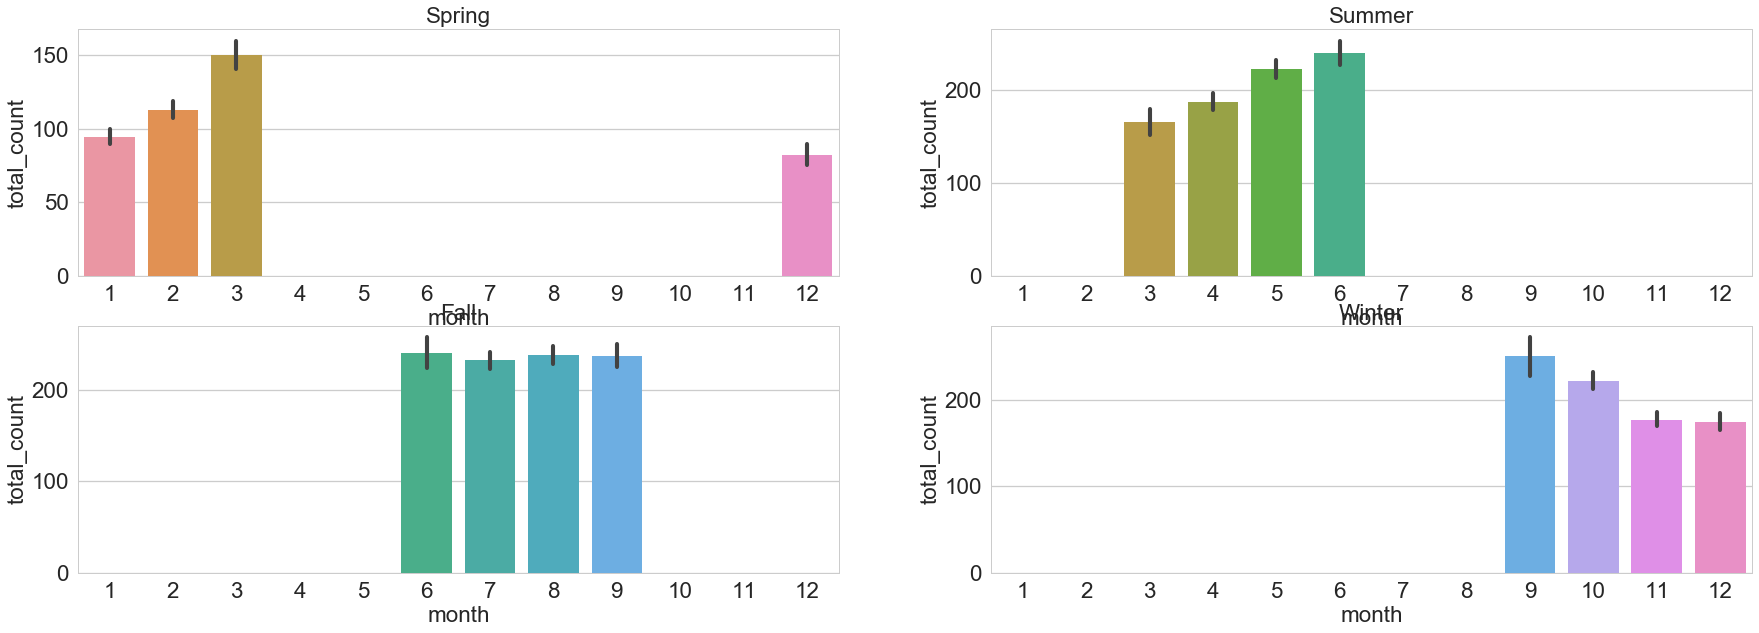

In [13]:
df_col_list = ['month','weekday','total_count']
plot_col_list= ['month','total_count']
spring_df = hour_df[hour_df.season==1][df_col_list]
summer_df = hour_df[hour_df.season==2][df_col_list]
fall_df = hour_df[hour_df.season==3][df_col_list]
winter_df = hour_df[hour_df.season==4][df_col_list]

fig,ax= plt.subplots(nrows=2,ncols=2)
sn.barplot(data=spring_df[plot_col_list],x="month",y="total_count",ax=ax[0][0],)
ax[0][0].set(title="Spring")

sn.barplot(data=summer_df[plot_col_list],x="month",y="total_count",ax=ax[0][1])
ax[0][1].set(title="Summer")

sn.barplot(data=fall_df[plot_col_list],x="month",y="total_count",ax=ax[1][0])
ax[1][0].set(title="Fall")

sn.barplot(data=winter_df[plot_col_list],x="month",y="total_count",ax=ax[1][1])  
ax[1][1].set(title="Winter");

### Year Wise Count Distributions

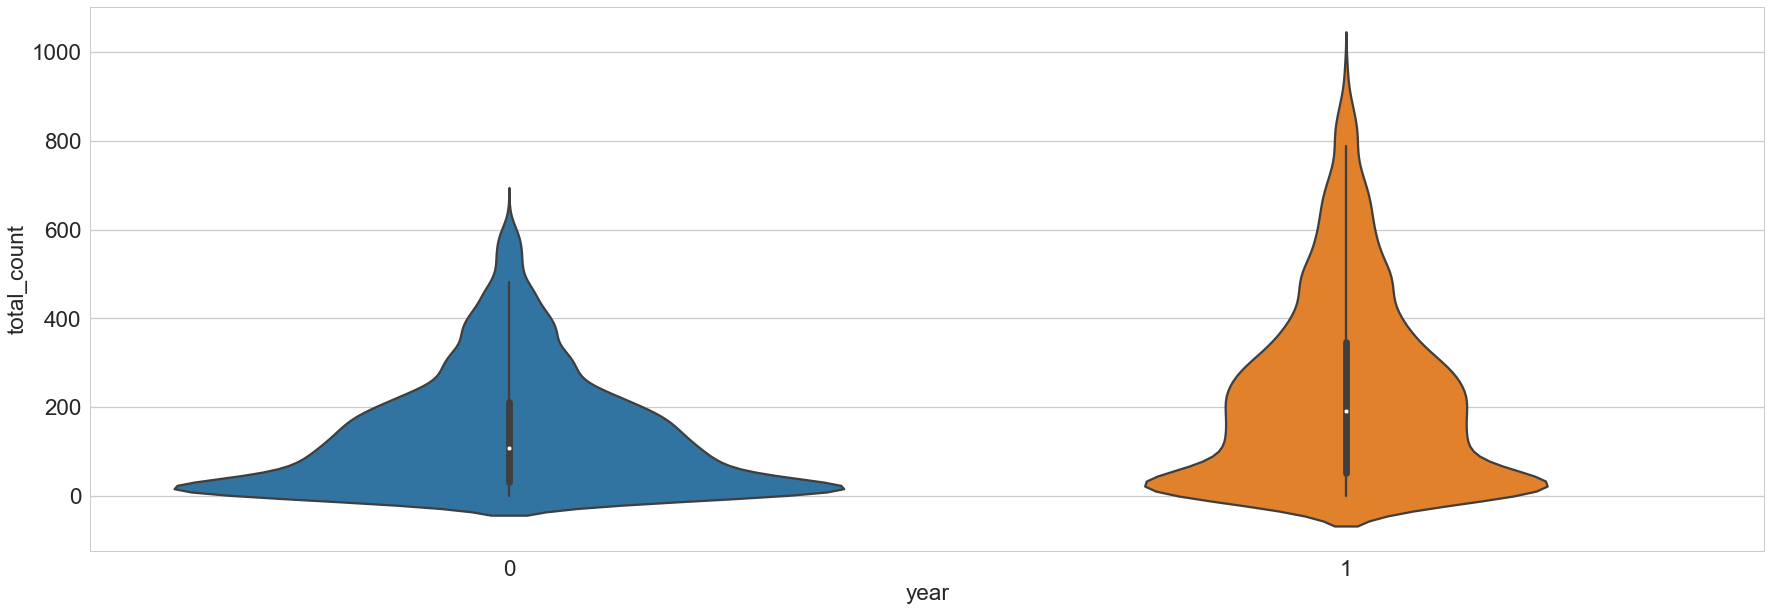

In [14]:
sn.violinplot(data=hour_df[['year',
                            'total_count']],
              x="year",y="total_count");

+ Both years have multimodal distributions
+ 2011 has lower counts overall with a lower median
+ 2012 has a higher max count though the peaks are around 100 and 300 which is then tapering off

### Working Day Vs Holiday Distribution

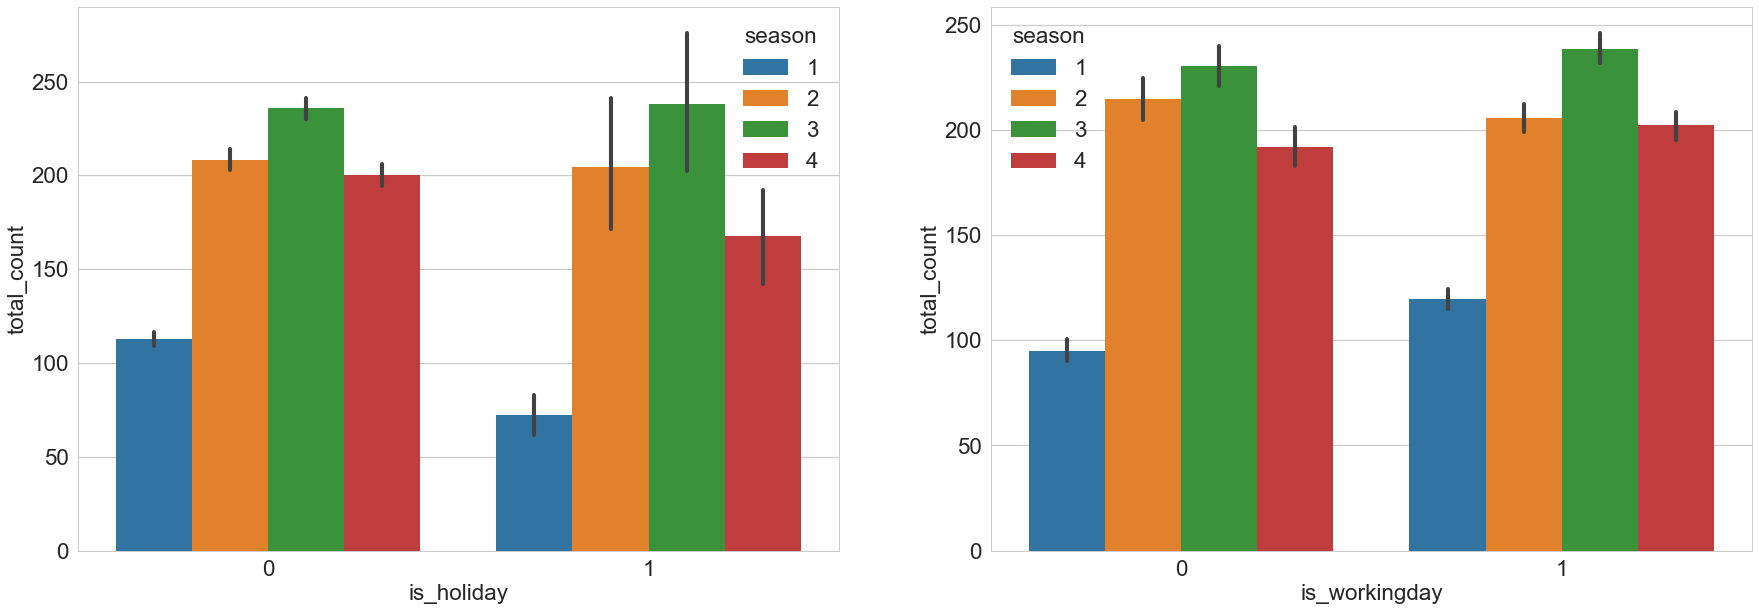

In [15]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
sn.barplot(data=hour_df,x='is_holiday',y='total_count',hue='season',ax=ax1)
sn.barplot(data=hour_df,x='is_workingday',y='total_count',hue='season',ax=ax2);

### Outliers

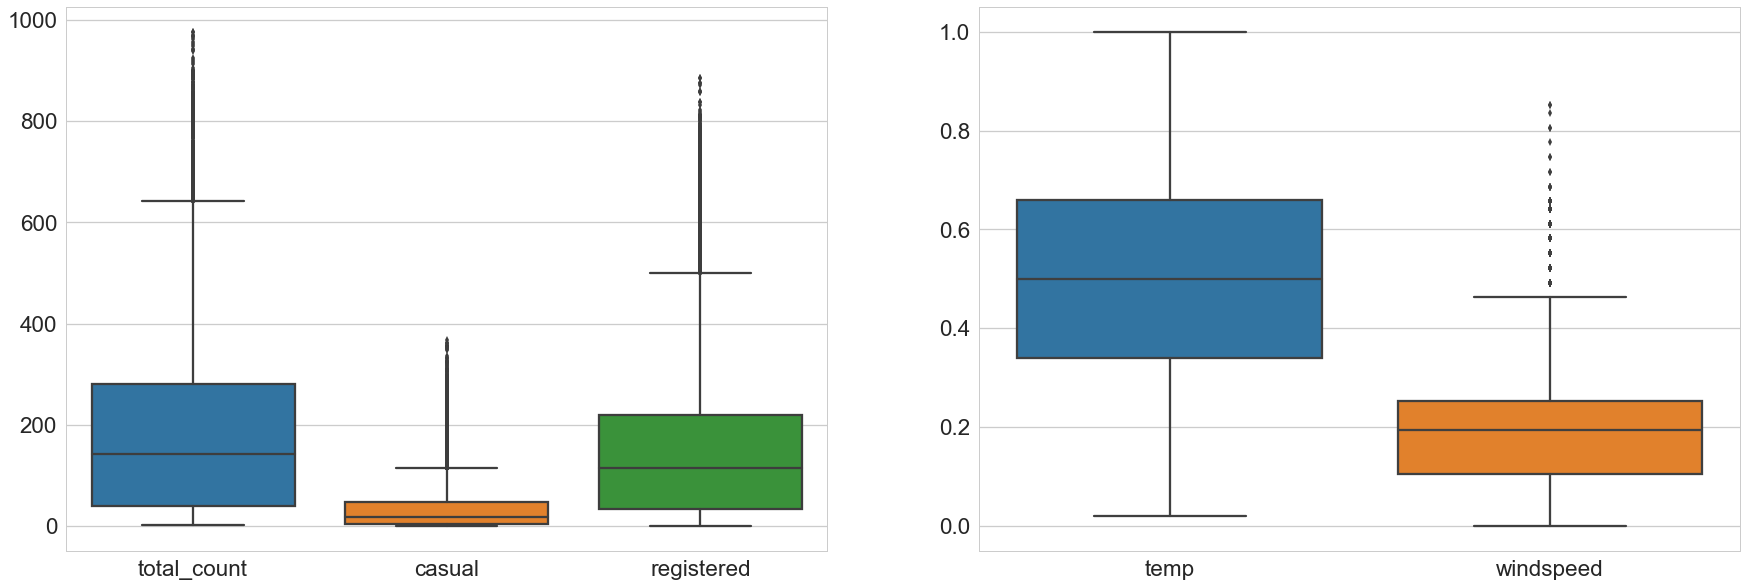

In [16]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
sn.boxplot(data=hour_df[['total_count',
                         'casual','registered']],ax=ax1)
sn.boxplot(data=hour_df[['temp','windspeed']],ax=ax2);

### Correlations

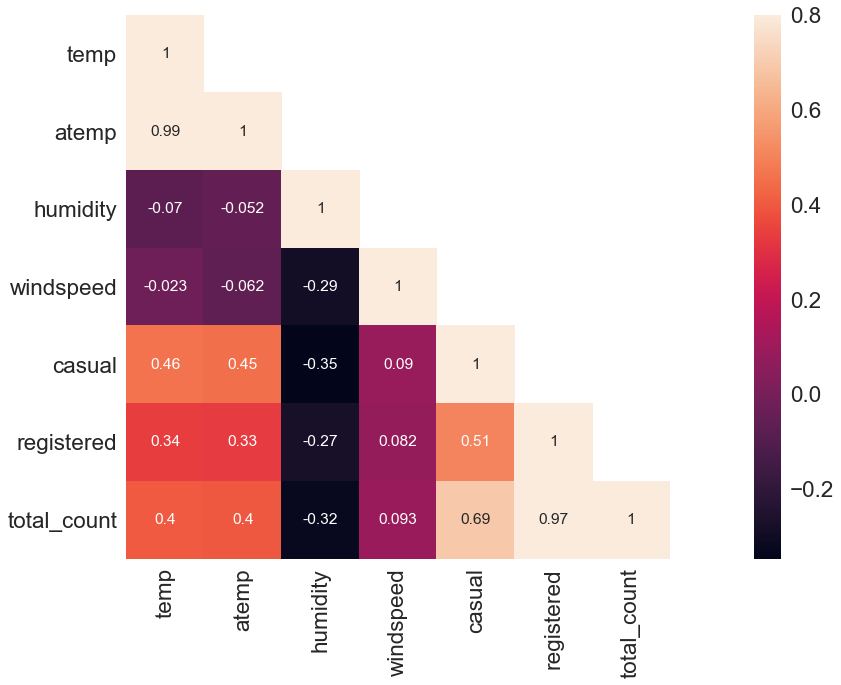

In [17]:
corrMatt = hour_df[["temp","atemp",
                    "humidity","windspeed",
                    "casual","registered",
                    "total_count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sn.heatmap(corrMatt, mask=mask,
           vmax=.8, square=True,annot=True);

+ Correlation between temp and atemp is very high (as expected)
+ Same is te case with registered-total_count and casual-total_count
+ Windspeed to humidity has negative correlation
+ Overall correlational statistics are not very high.

# Start with a linear regression model

### Encode Categoricals (One Hot Encoding)

In [18]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
        column.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded

    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series

    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

## Train-Test split

In [19]:
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:,-1], 
                                                    test_size=0.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


## Normality test

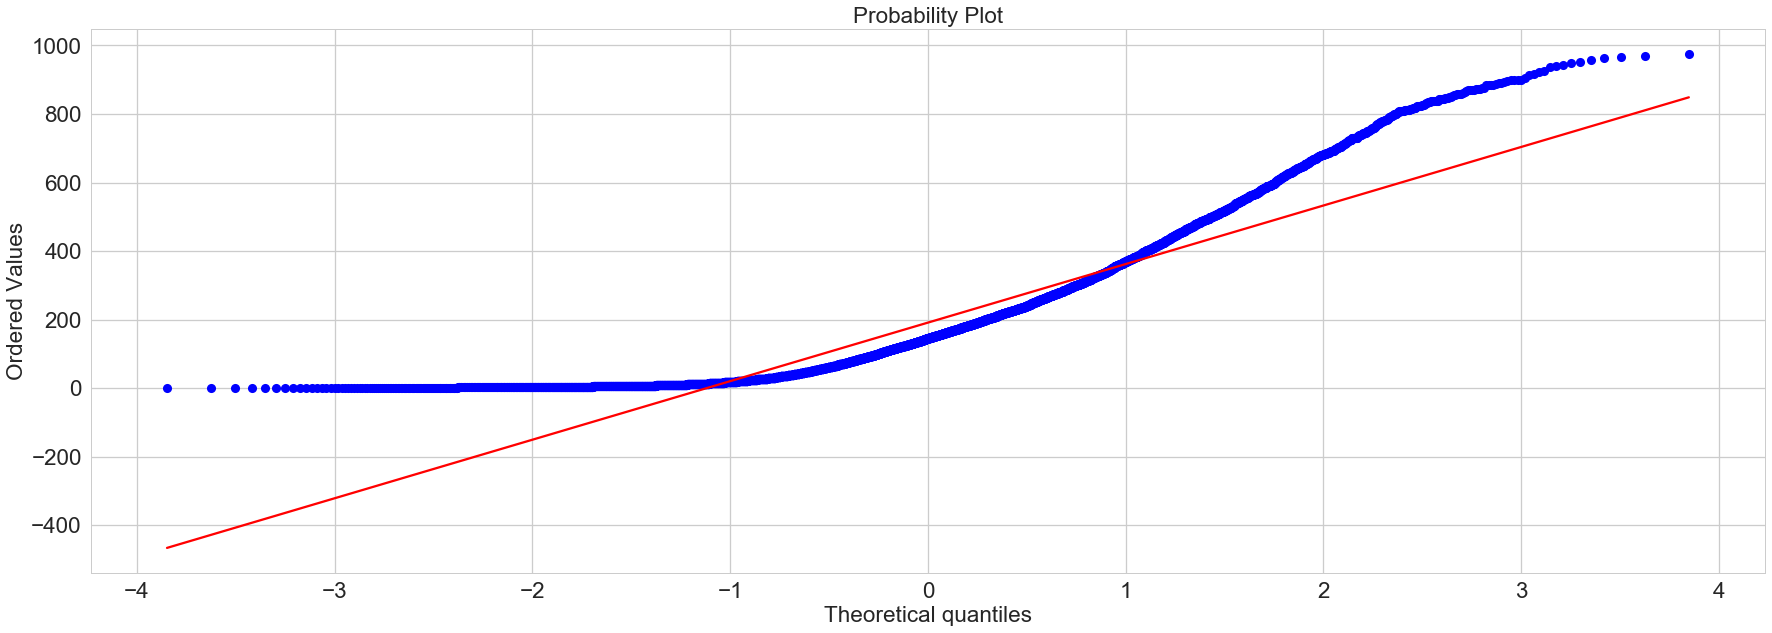

In [20]:
stats.probplot(y.total_count.tolist(), dist="norm", plot=plt)
plt.show()

In [21]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [22]:
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

In [23]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


## Linear regression

In [24]:
X = train_df_new
y= y.total_count.values.reshape(-1,1)

lin_reg = linear_model.LinearRegression()

## Cross validation

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


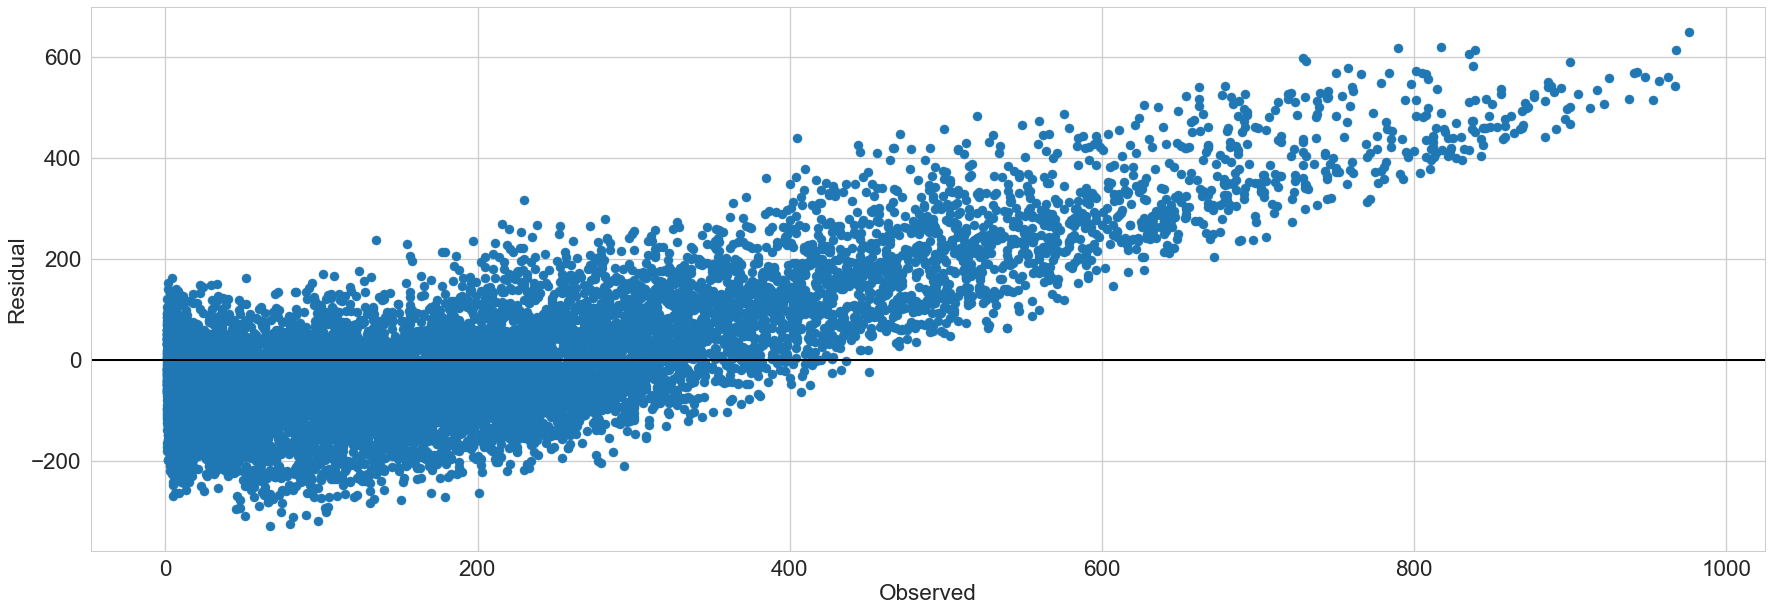

In [25]:
predicted = cross_val_predict(lin_reg, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, y-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [26]:
r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse_scores = cross_val_score(lin_reg, X, y, cv=10,scoring='neg_mean_squared_error')

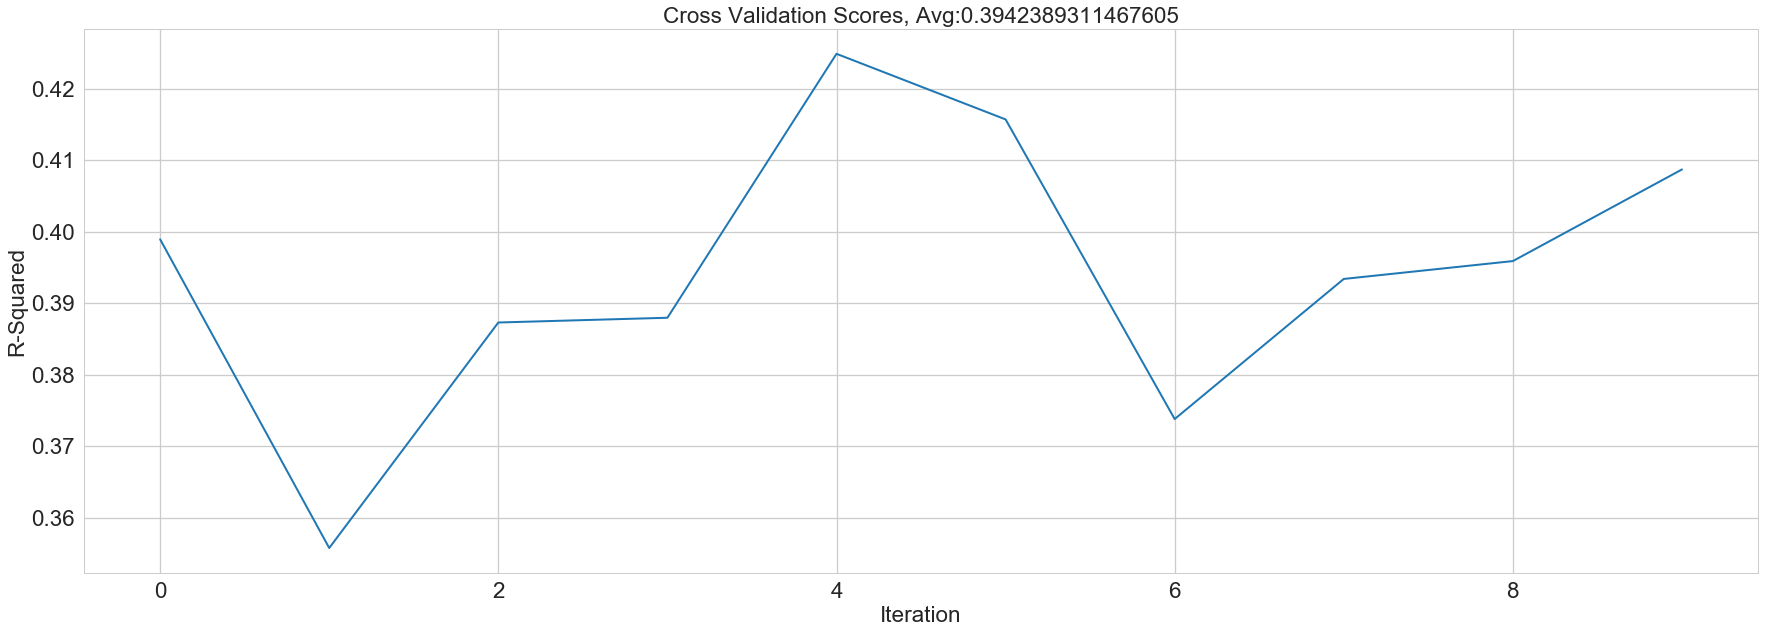

In [27]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [28]:
print("R-squared::{}".format(r2_scores))
print("MSE::{}".format(mse_scores))

R-squared::[0.39893766 0.35575732 0.3873037  0.38796861 0.42489499 0.41571719
 0.37379762 0.39339864 0.39589746 0.40871611]
MSE::[-19612.60975491 -20800.77110185 -20256.54013607 -18545.99033804
 -18746.57816436 -21015.15593077 -21549.12876053 -21567.27946203
 -21044.42416385 -18899.05989574]


In [29]:
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Test set performance

In [30]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,
                                                              le,ohe,
                                                              col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [31]:
test_df_new.head()

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.80,0.27,0.1940,19,6,6,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.24,0.41,0.2239,20,1,1,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.32,0.66,0.2836,2,5,10,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.78,0.52,0.3582,19,2,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.26,0.56,0.3881,0,4,1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [32]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

y_pred = lin_reg.predict(X_test)

residuals = y_test-y_pred

In [33]:
r2_score = lin_reg.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.4024409682673428
MSE: 19063.00


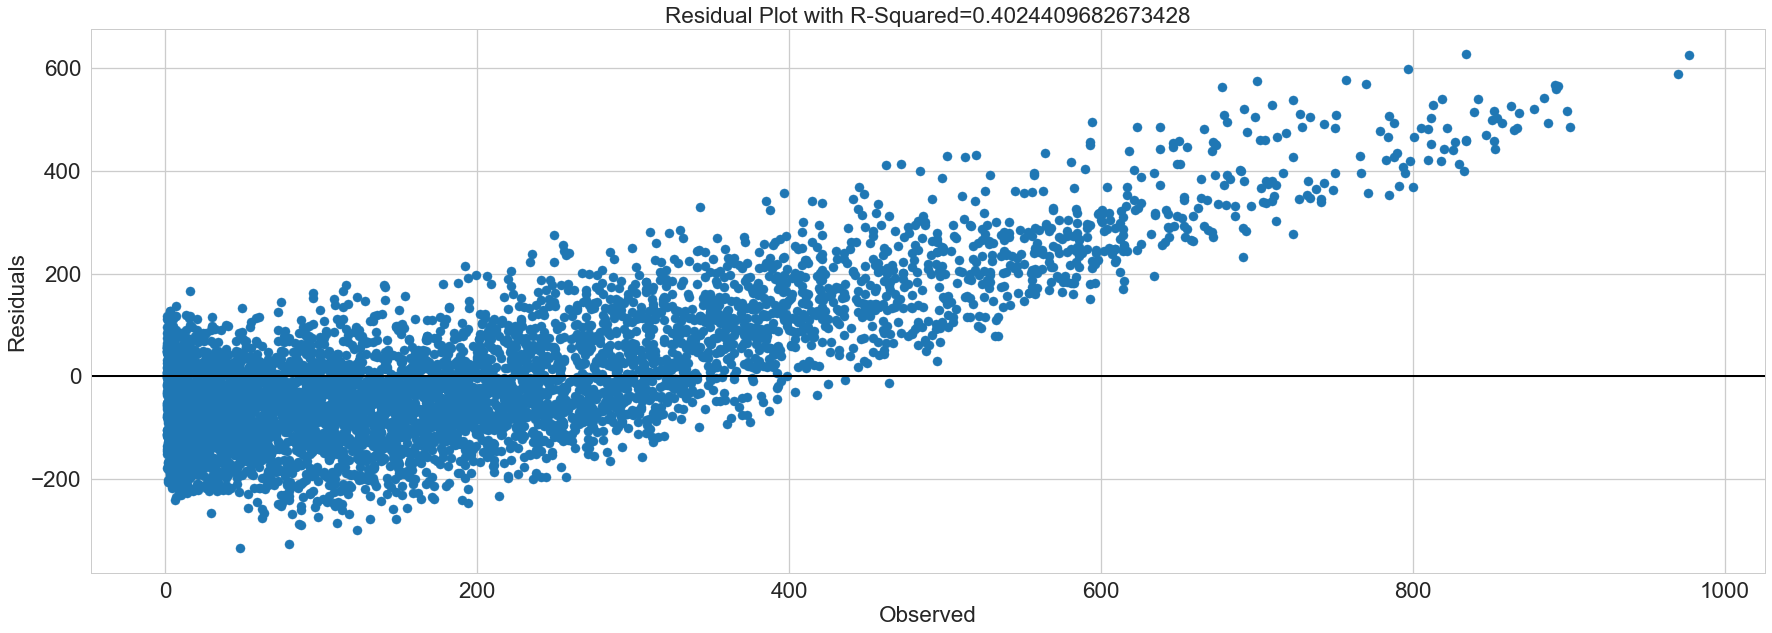

In [34]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot with R-Squared={}".format(np.average(r2_score)))
plt.show()

## Statsmodels

In [35]:
import statsmodels.api as sm

# Set the independent variable
X = X.values.tolist()

# This handles the intercept. 
# Statsmodel takes 0 intercept by default
X = sm.add_constant(X)

X_test = X_test.values.tolist()
X_test = sm.add_constant(X_test)


# Build OLS model
model = sm.OLS(y, X)
results = model.fit()

# Get the predicted values for dependent variable
pred_y = results.predict(X_test)

# View Model stats
print(results.summary())

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     508.2
Date:                Thu, 02 Aug 2018   Prob (F-statistic):               0.00
Time:                        19:58:42   Log-Likelihood:                -74221.
No. Observations:               11643   AIC:                         1.485e+05
Df Residuals:                   11627   BIC:                         1.486e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3509     11.086     -0.122      0.9

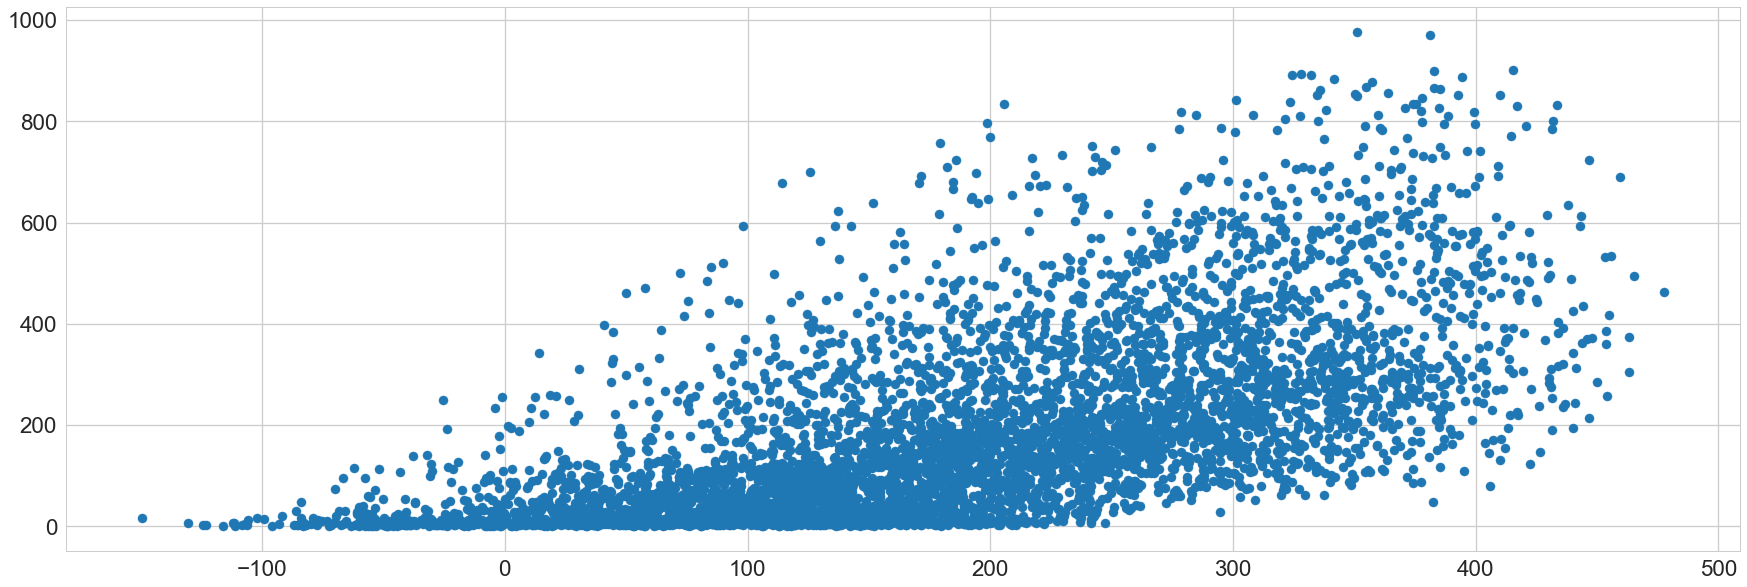

In [36]:
plt.scatter(pred_y,y_test);

# Decision tree regressor

In [37]:
X.shape,y.shape # same as above

((11643, 20), (11643, 1))

In [39]:
# modeling utilities
import pydotplus 
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [40]:
dtr = DecisionTreeRegressor(max_depth=4,
                            min_samples_split=5,
                            max_leaf_nodes=10)
dtr.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [41]:
dtr.score(X,y)

0.6056576562103779

## Plot the learn model 

dot_data = tree.export_graphviz(dtr, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("models/bikeshare.pdf") 

### Grid Search With Cross Validation

In [42]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100, 500, 800],
              }

In [43]:
grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5)

In [45]:
%%time
grid_cv_dtr.fit(X,y)

Wall time: 24min 41s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['mse', 'mae'], 'min_samples_split': [10, 20, 40], 'max_depth': [2, 6, 8], 'min_samples_leaf': [20, 40, 100], 'max_leaf_nodes': [5, 20, 100, 500, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Cross Validation: Best Model Details

In [46]:
print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))

R-Squared::0.85891903233008
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 500, 'min_samples_leaf': 20, 'min_samples_split': 40}


In [47]:
df = pd.DataFrame(data=grid_cv_dtr.cv_results_)
df.head()

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009079,0.002289,0.000199,0.000398,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_split': 10}",...,0.48401,0.007223,217,0.491806,0.483696,0.48915,0.491167,0.487932,0.48875,0.002883
1,0.007380,0.001354,0.000598,0.000488,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_split': 20}",...,0.48401,0.007223,217,0.491806,0.483696,0.48915,0.491167,0.487932,0.48875,0.002883
2,0.006987,0.000013,0.000200,0.000400,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_split': 40}",...,0.48401,0.007223,217,0.491806,0.483696,0.48915,0.491167,0.487932,0.48875,0.002883
3,0.006598,0.000473,0.000400,0.000490,mse,2,5,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 40, 'min_samples_split': 10}",...,0.48401,0.007223,217,0.491806,0.483696,0.48915,0.491167,0.487932,0.48875,0.002883
4,0.006780,0.000399,0.000398,0.000488,mse,2,5,40,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 40, 'min_samples_split': 20}",...,0.48401,0.007223,217,0.491806,0.483696,0.48915,0.491167,0.487932,0.48875,0.002883


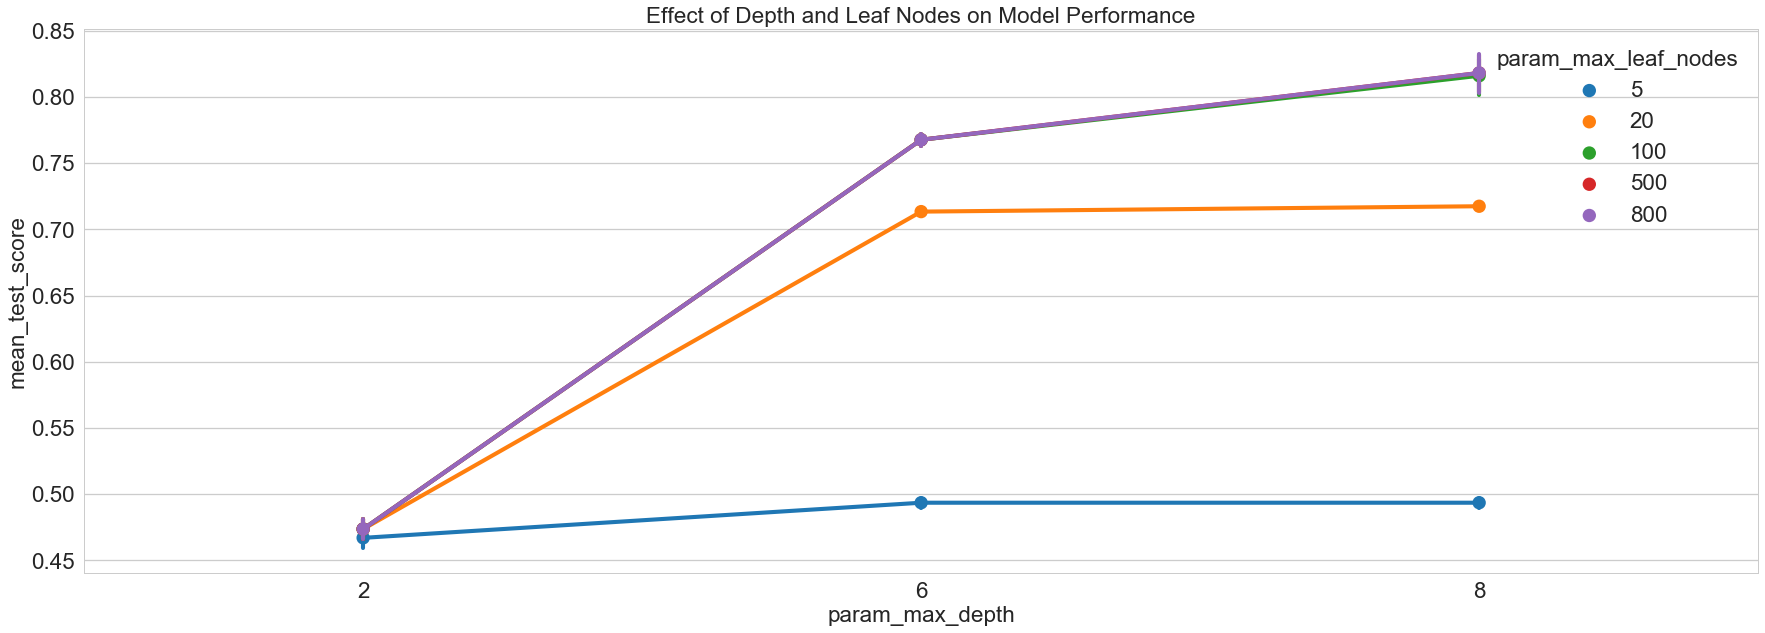

In [48]:
fig,ax = plt.subplots()
sn.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance");

### Residual Plot

In [49]:
predicted = grid_cv_dtr.best_estimator_.predict(X)
residuals = y.flatten()-predicted

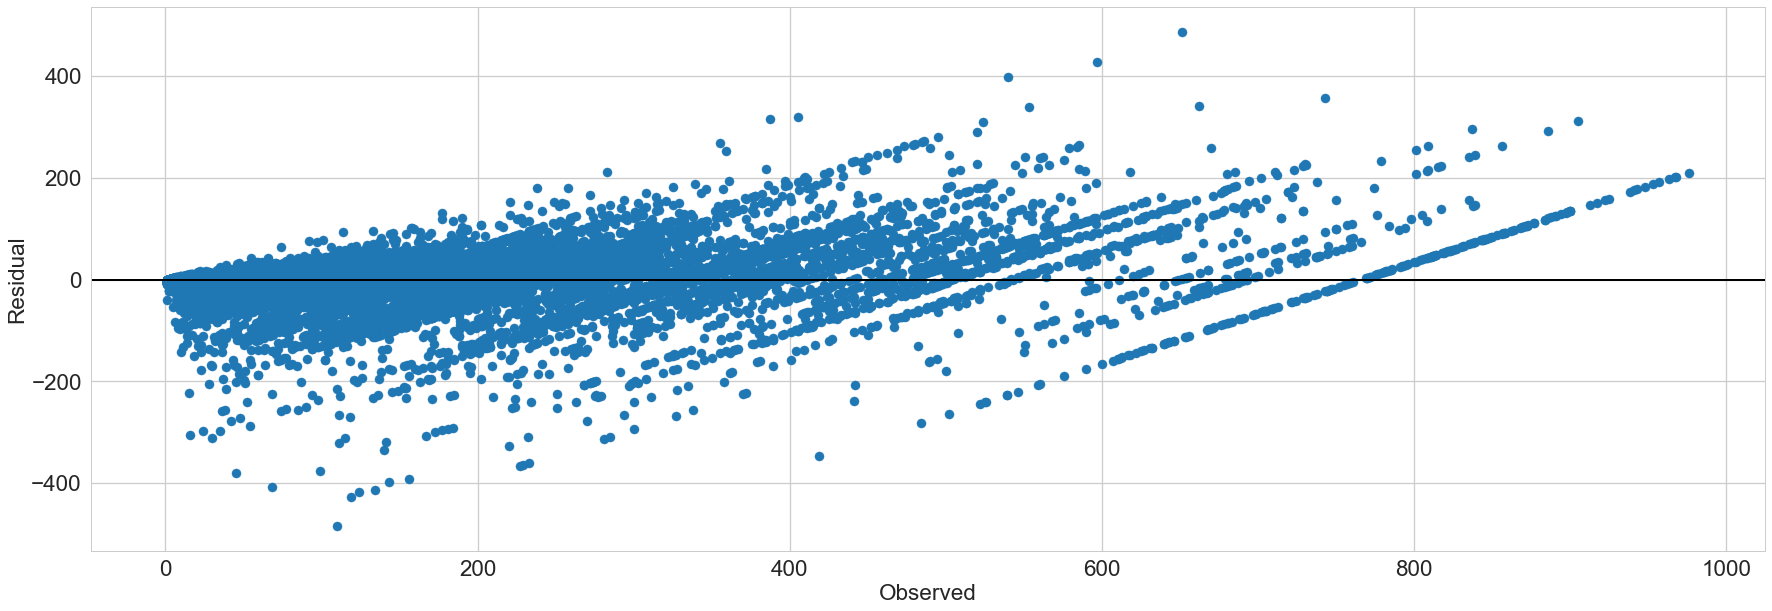

In [50]:
fig, ax = plt.subplots()
ax.scatter(y.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [51]:
r2_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10)
mse_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10,scoring='neg_mean_squared_error')

In [52]:
print("avg R-squared::{}".format(np.mean(r2_scores)))
print("MSE::{}".format(np.mean(mse_scores)))

avg R-squared::0.8634248558271074
MSE::-4546.657848020102


### Setting the model for Testing

In [53]:
best_dtr_model = grid_cv_dtr.best_estimator_

## Test Dataset Performance

In [54]:
# test sample same as above
y_pred = best_dtr_model.predict(X_test)
residuals = y_test.flatten() - y_pred

In [55]:
r2_score = best_dtr_model.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.8722059567160857
MSE: 4076.82


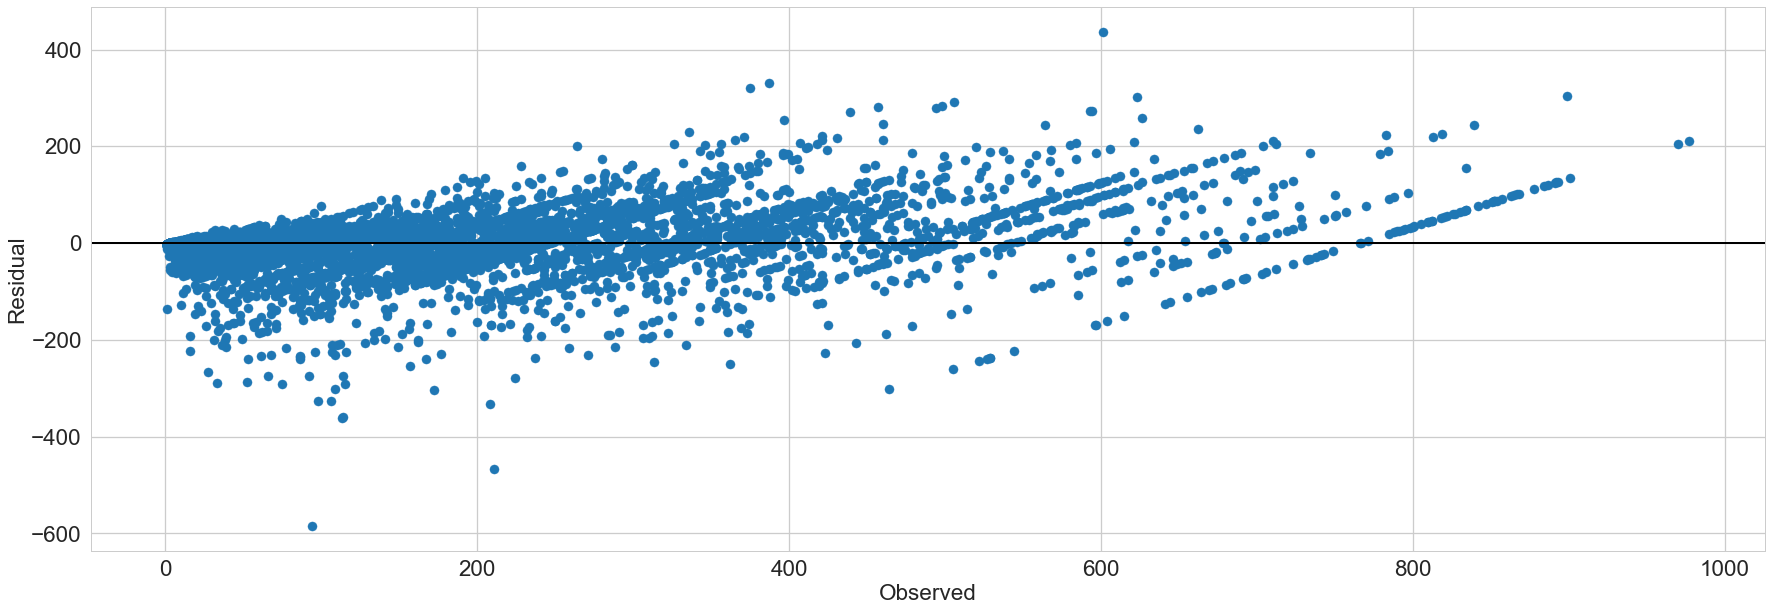

In [56]:
fig, ax = plt.subplots()
ax.scatter(y_test.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

r2_score = grid_cv_dtr.best_estimator_.score(X_test,y_test)